# Krypton waveform NB

- First day of stable data taking for Run III
- Fresh source of Krypton. Suspect intensity is high, perhaps originating too much scintillation.

## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-03 18:24:05


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

In [6]:
from typing      import NamedTuple

## NB functions

In [7]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [43]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [44]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [48]:
def plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min, t_max):

    sipm_sums = np.sum(sipm_cal, axis=0)
    
    t = np.arange(len(cwf_sum)) / 40
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, cwf_sum)
    plt.xlim(t_min , t_max )

    plt.subplot(2, 1, 2)
    plt.plot(sipm_sums)
    plt.xlim(t_min, t_max)


In [62]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

In [11]:
def display_s12s(s12s):
    for s12 in s12s:
        print('energy = {} pes charge = {} pes time = {} mus width = {} ns'.format(
        s12.total_energy, s12.total_charge, s12.time_at_max_energy/units.mus, s12.width))

In [12]:
def plot_sipm_signals_vs_time_mus(sipm_signals,
                                  sipm_min      =    0,
                                  sipm_max      = 2000,
                                 figsize=(6,6)):
    """Plot PMT signals versus time in mus  and return figure."""


    plt.figure(figsize=figsize)   
    plt.ylabel(r'q (pes/adc)')
    plt.xlabel(r'sipm number ')
    ax = plt.subplot()
    ax.set_xlim([sipm_min, min(sipm_max, len(sipm_signals))])
    plt.grid(True)
    plt.plot(sipm_signals)
       


In [13]:
def sort_s12s(s12s):
    return sorted(s12s, key= lambda s12 : s12.total_energy, reverse=True)

In [14]:
def kr_dst(s1s, s2s, xs, ys):
    s1 = sort_s12s(s1s)[0]
    s2 = sort_s12s(s2s)[0]
    c = compute_xy_peak_position(s2.sipms, xs, ys)
    
    return KrDst(es1 = s1.total_energy, ws1=s1.width, 
                 es2 =s2.total_energy,  ws2=s1.width, qs2=s2.total_charge, 
                 dt = (s2.time_at_max_energy - s1.time_at_max_energy) / units.mus,
                 c = c)
    

In [15]:
class Cluster(NamedTuple):
    Q     : float
    x     : float 
    y     : float
    nsipm : int

In [16]:
class KrDst(NamedTuple):
    es1  : float
    ws1  : float
    es2  : float
    ws2  : float
    qs2  : float
    dt   : float 
    c    : Cluster


In [17]:
def compute_xy_peak_position(sr, xs, ys):
        """
        Computes position using the integral of the charge
        in each SiPM. Config parameters set equal to the standard kDST values.
        """
        IDs = sr.ids
        Qs = sr.sum_over_times
        xs, ys   = xs[IDs], ys[IDs]
        cls      = corona(np.stack((xs, ys), axis=1), Qs,
                      Qthr           =  1.,
                      Qlm            =  0.,
                      lm_radius      =  -1.,
                      new_lm_radius  =  -1.,
                      msipm          =  1)
        c = cls[0]
        return Cluster(Q=c.Q, x=c._xy.x, y=c._xy.y, nsipm=c.nsipm)


In [18]:
KR = []

## Data base

In [19]:
run_number = 5227
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [20]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [21]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,27.346,0.77,11.551
1,1,16,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,28.257,0.00,12.848
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,29.983,0.81,12.072
3,3,17,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,30.131,0.00,12.006
4,4,29,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,36.064,0.00,13.448
5,5,28,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,26.945,0.00,9.687
6,6,13,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,31.032,0.00,11.675
7,7,12,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,40.055,0.00,15.462
8,8,4,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,28.566,0.77,11.466
9,9,24,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,0.000,0.00,0.000


In [22]:
channel_id

array([ 0, 16,  1, 17, 29, 28, 13, 12,  4, 24,  9,  8])

In [23]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

In [24]:
sipm_adc_to_pes[181] = 0

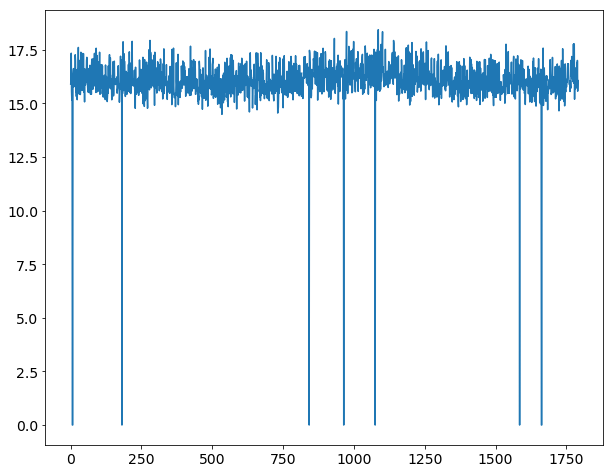

In [25]:
plt.plot(sipm_adc_to_pes)

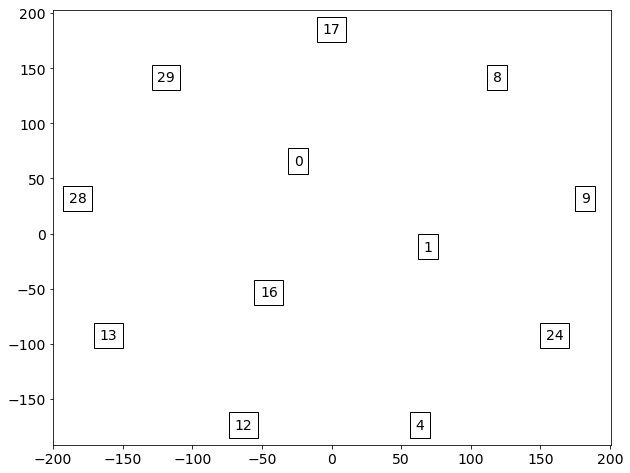

In [26]:
mpl.draw_pmt_map(run_number)

In [27]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,   0.   ,  26.082,  27.499])

In [28]:
adc_to_pes[9] = 25

In [29]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,  25.   ,  26.082,  27.499])

## Input file

In [30]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5227_0070_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [31]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [32]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [33]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [34]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [35]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

### Event

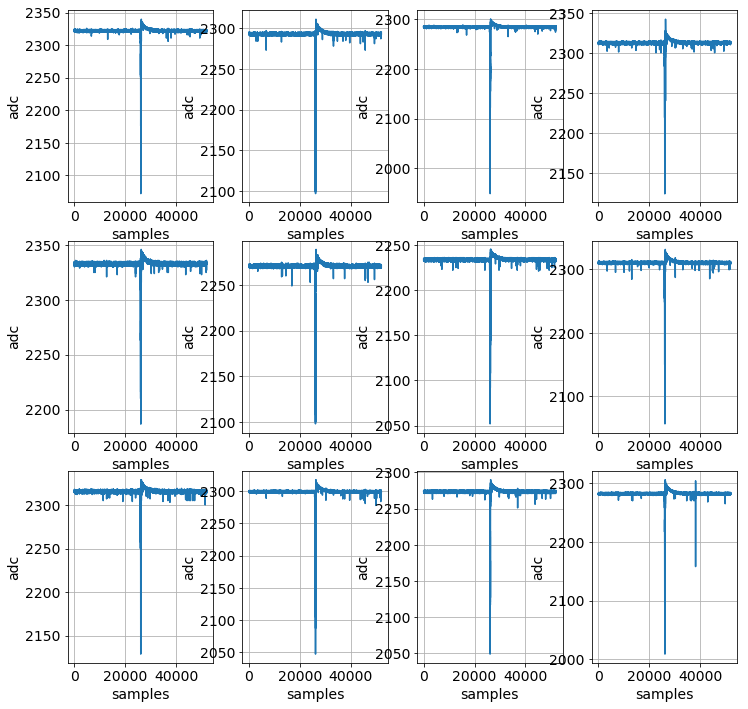

In [85]:
event=0
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

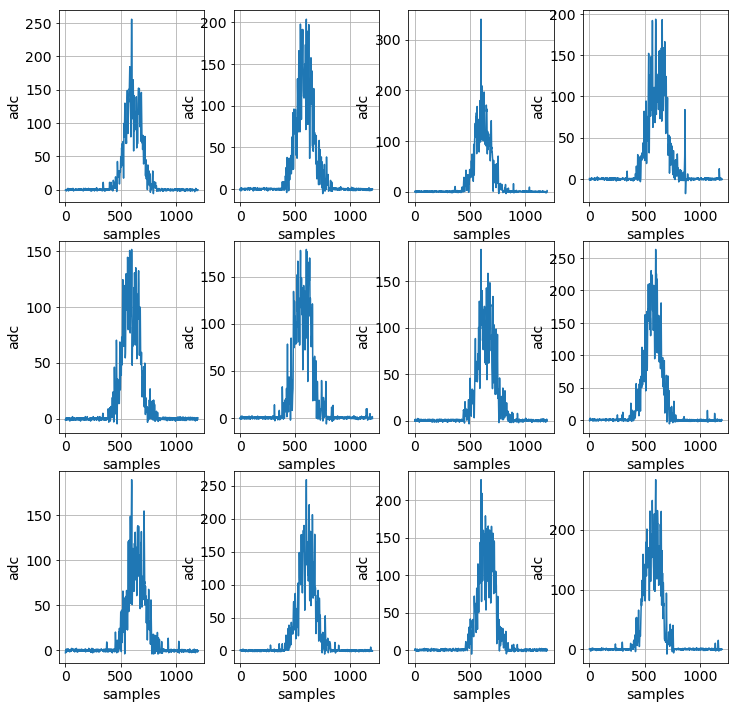

In [71]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

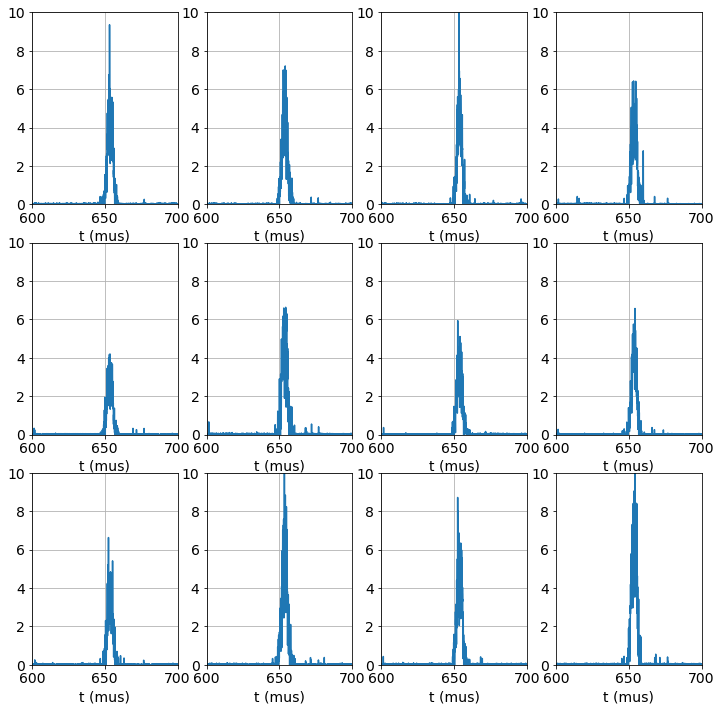

In [72]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

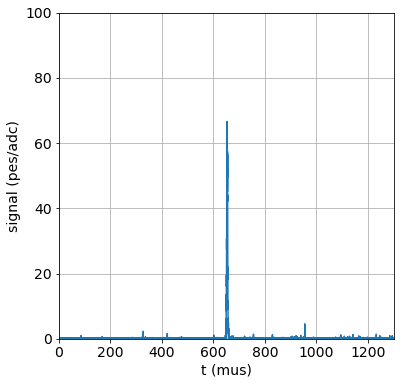

In [73]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

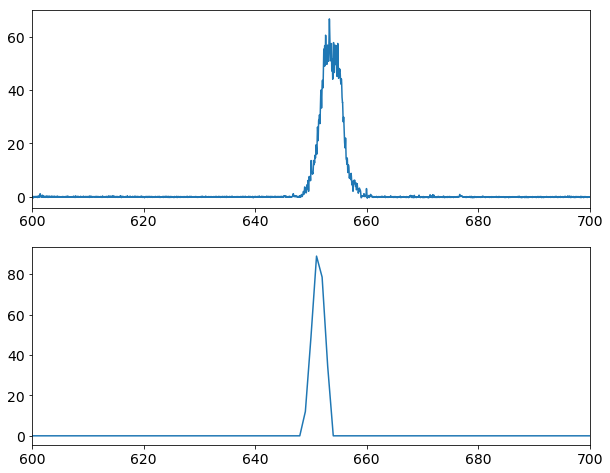

In [74]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

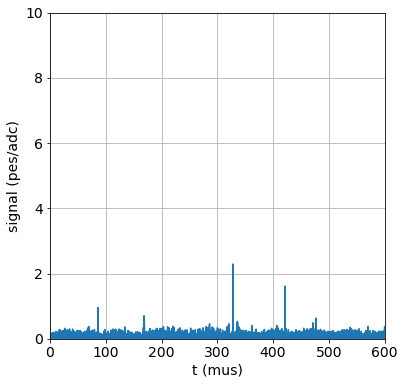

In [75]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

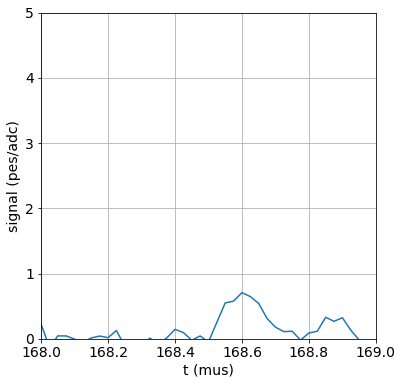

In [54]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =168,
                            t_max      = 169,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

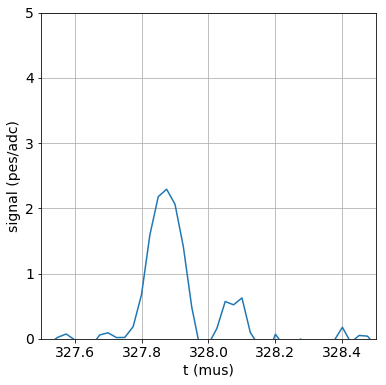

In [56]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =327.5,
                            t_max      = 328.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

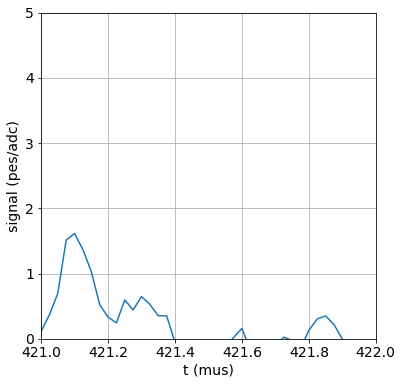

In [57]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =421,
                            t_max      = 422,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

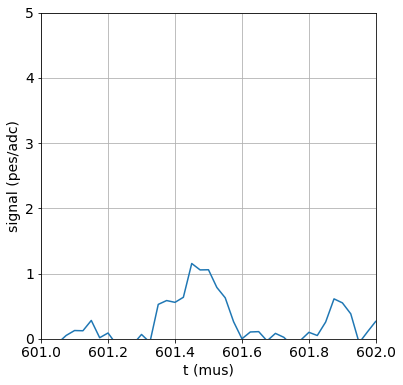

In [58]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =601,
                            t_max      = 602,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [51]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 168.575  168.6    168.625  168.65 ] µs
 Time @ max energy: 168.6
 Width: 0.075 µs
 Height: 0.7072408042181957 pes
 Energy: 2.4742192071211413 pes
 Charge: 0.0 pes
 RMS: 0.02685282550403136 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 327.8    327.825  327.85   327.875  327.9    327.925] µs
 Time @ max energy: 327.875
 Width: 0.125 µs
 Height: 2.292693877589096 pes
 Energy: 10.215338616685417 pes
 Charge: 0.0 pes
 RMS: 0.03646127113317619 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 421.05   421.075  421.1    421.125  421.15   421.175  421.2    421.225
 421.25   421.275  421.3    421.325] µs
       Time @ max energy: 421.1
       Width: 0.275 µs
       Height: 1.613478178025096 pes
       Energy: 9.538323074891144 pes
       Charge: 0.0 pes
       RMS: 0.0833089654

In [60]:
s2params = S12Params(time = minmax(min    = 600 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 40, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 648.80795798  649.60628609  650.54597092  651.55050128  652.50606625
 653.47371128  654.47936132  655.4340474   656.40156545  657.44037188
 658.39837521  659.72567728  660.        ] µs
       Time @ max energy: 653.473711282215
       Width: 11.192042018538341 µs
       Height: 2145.9356569017746 pes
       Energy: 10564.70245739668 pes
       Charge: 262.59702695419793 pes
       RMS: 1.7867993744608088 µs]

[[288]
 [289]
 [296]
 [299]
 [300]
 [301]
 [302]]


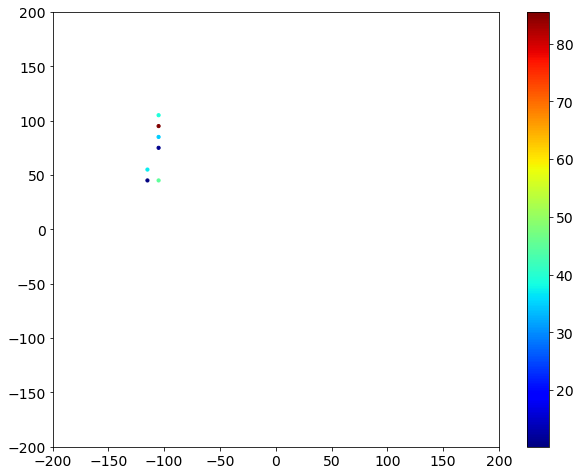

In [63]:
plot_sipm_map(sipm_cal)

#### Elements to discern S1

- Total energy (order 10 pes)
- Height (more than 1 pes, probably close to 1.5 to 2 pes)
- ratio Height to total energy
- ratio Height to Width

### Event

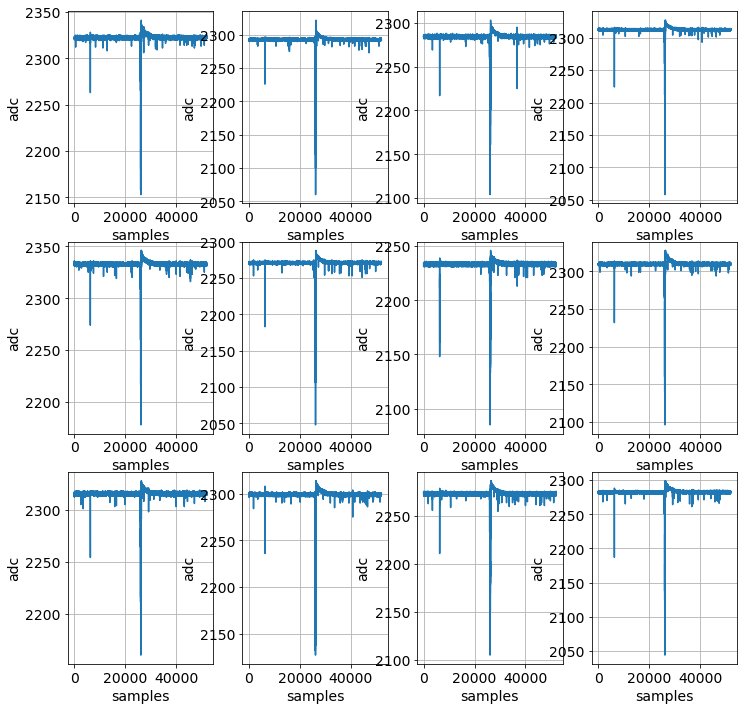

In [86]:
event=1
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

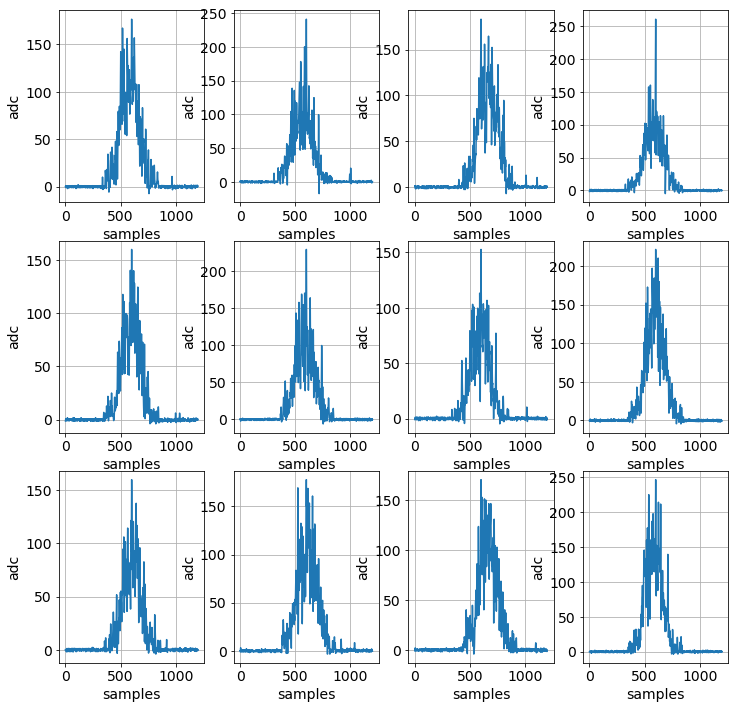

In [87]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=600, figsize=(12,12))

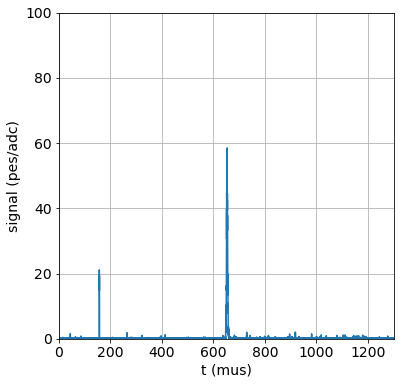

In [88]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

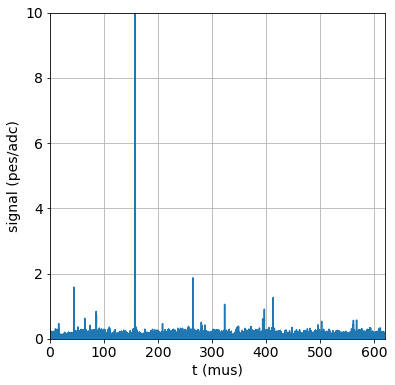

In [89]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

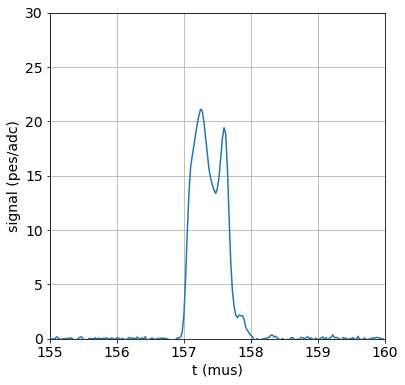

In [90]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =155,
                            t_max      = 160,
                            signal_min =    0,
                            signal_max =  30,
                            figsize=(6,6))

[]


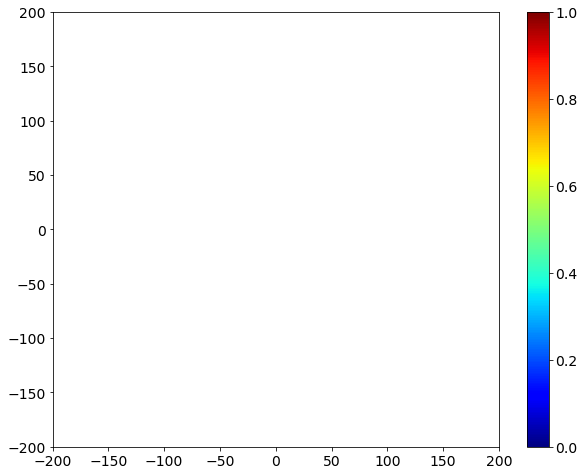

In [92]:
plot_sipm_map(sipm_cal, t_min=155, t_max=160)

In [93]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 264.75   264.775  264.8    264.825  264.85   264.875  264.9  ] µs
 Time @ max energy: 264.8
 Width: 0.15 µs
 Height: 1.8686216727374112 pes
 Energy: 9.064062481651936 pes
 Charge: 0.0 pes
 RMS: 0.04179706291787617 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 323.375  323.4    323.425  323.45   323.475  323.5    323.525  323.55
 323.575  323.6    323.625  323.65 ] µs
       Time @ max energy: 323.5
       Width: 0.275 µs
       Height: 1.0565310322443042 pes
       Energy: 7.738984269635406 pes
       Charge: 0.0 pes
       RMS: 0.0818115631445772 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 396.95   396.975  397.     397.025  397.05   397.075  397.1    397.125
 397.15   397.175] µs
       Time @ max energy: 397.025
       Width: 0.22

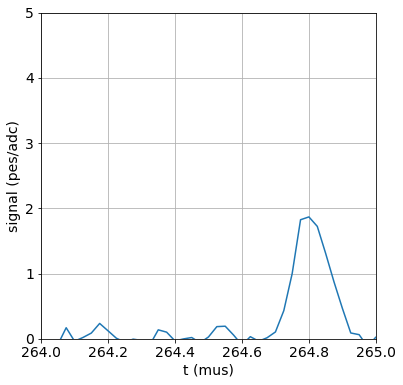

In [94]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =264,
                            t_max      = 265,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

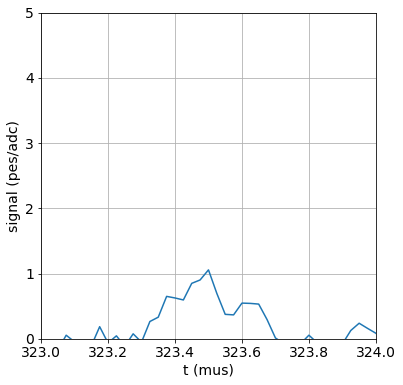

In [95]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =323,
                            t_max      = 324,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

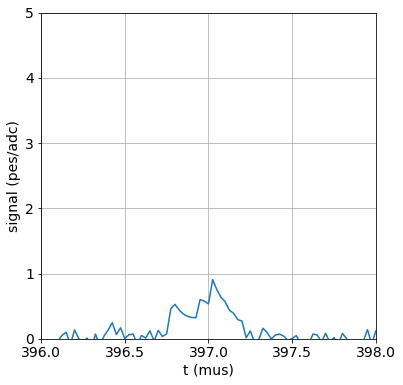

In [96]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =396,
                            t_max      = 398,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

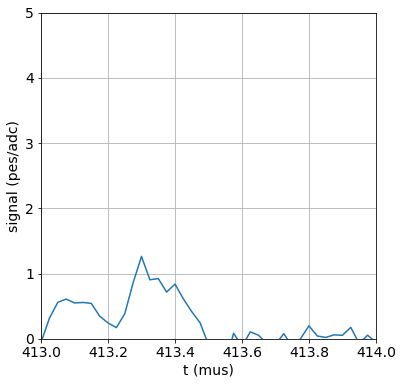

In [97]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =413,
                            t_max      = 414,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [99]:
s2params = S12Params(time = minmax(min    = 620 * units.mus,
                                   max    = 720 * units.mus),
                           stride = 40,
                           length = minmax(min = 4, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 647.8661932   648.51187537  649.49658403  650.58029519  651.52352622
 652.49451993  653.50762493  654.47057659  655.45289839  656.43493409
 657.36632223  658.44861668  659.49986229] µs
       Time @ max energy: 653.5076249268697
       Width: 11.633669085959323 µs
       Height: 1874.6858653342838 pes
       Energy: 9724.722474108503 pes
       Charge: 87.96931857922087 pes
       RMS: 2.066159585875902 µs]

[[1400]
 [1401]
 [1404]]


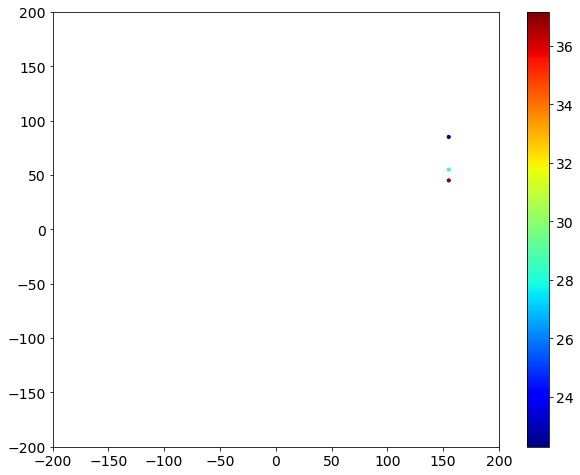

In [100]:
plot_sipm_map(sipm_cal)

In [101]:
kr_dst(s1s, s2s, xs, ys)

KrDst(es1=9.064062481651936, ws1=150.0, es2=9724.7224741085029, ws2=150.0, qs2=87.969318579220868, dt=388.70762492686964, c=Cluster(Q=87.969318579220868, x=155.00000000000003, y=58.378621540533693, nsipm=3))

### Event

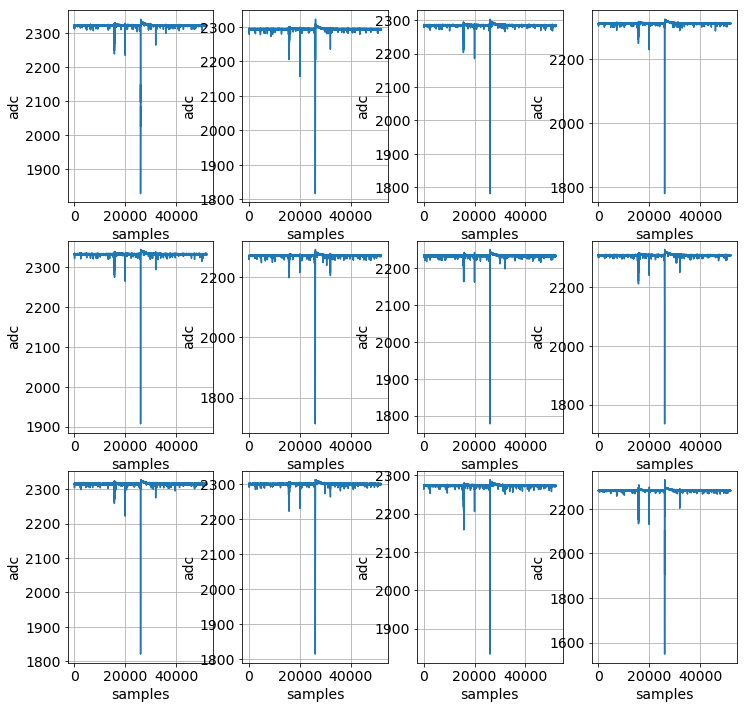

In [102]:
event=2
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

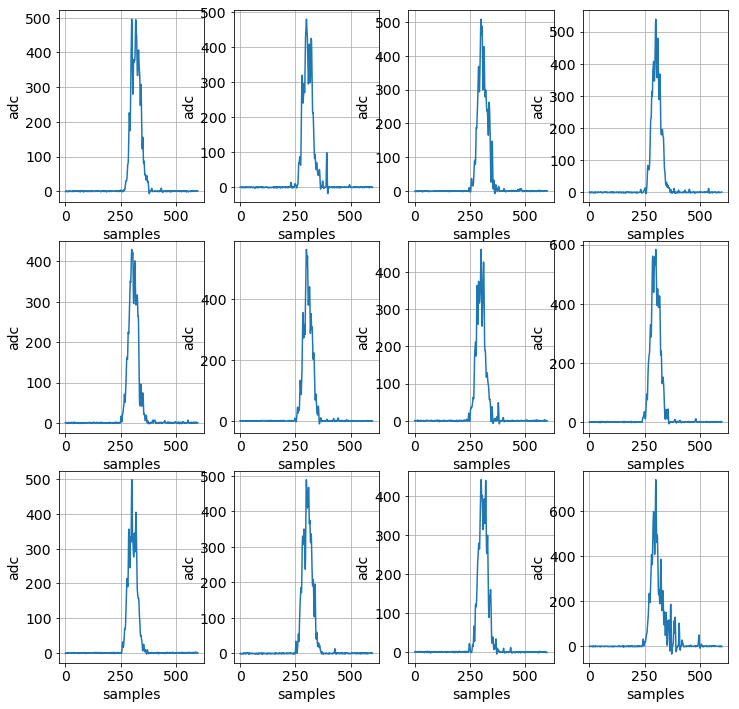

In [103]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=300, figsize=(12,12))

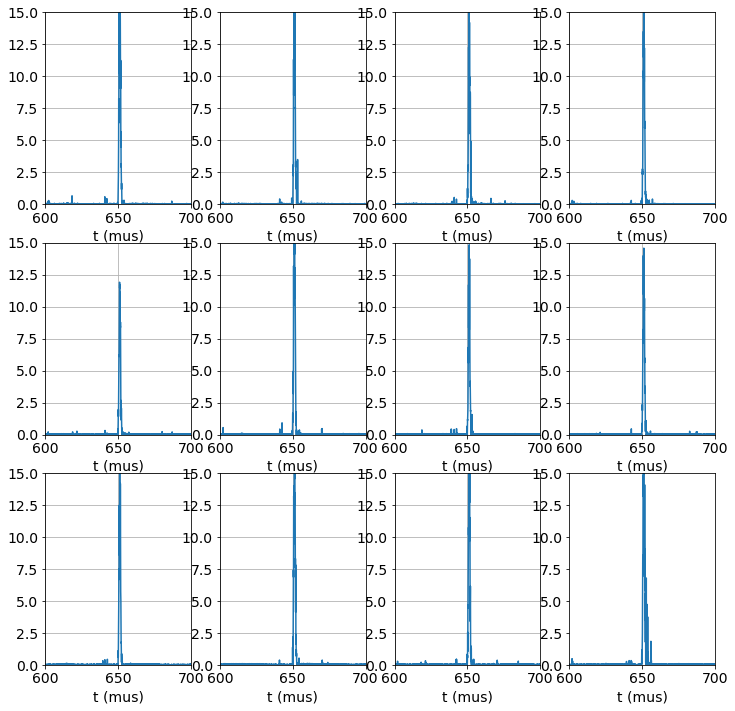

In [104]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    600,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  15,
                                 figsize=(12,12))

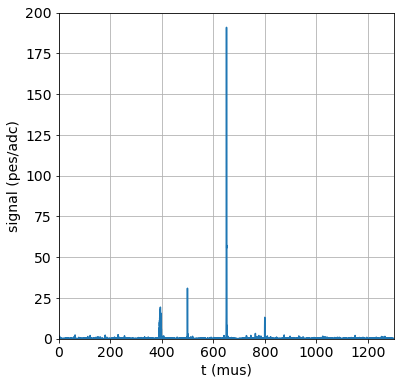

In [105]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

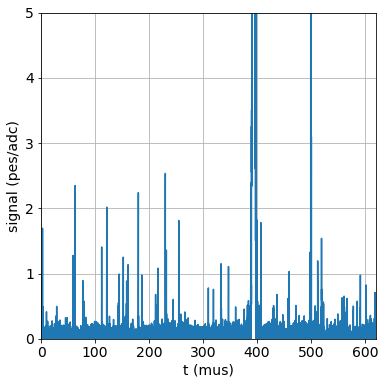

In [106]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [107]:
s1params = S12Params(time = minmax(min    = 120 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 121.55   121.575  121.6    121.625  121.65   121.675  121.7    121.725
 121.75   121.775  121.8    121.825  121.85   121.875] µs
       Time @ max energy: 121.65
       Width: 0.325 µs
       Height: 2.0178525767166664 pes
       Energy: 14.79152319036923 pes
       Charge: 0.0 pes
       RMS: 0.09127421752639149 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 144.7    144.725  144.75   144.775  144.8    144.825  144.85   144.875
 144.9  ] µs
       Time @ max energy: 144.75
       Width: 0.2 µs
       Height: 0.9923022556061303 pes
       Energy: 5.594808074847102 pes
       Charge: 0.0 pes
       RMS: 0.06008407462870498 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 152.075  152.1    152.125  152.15   152.

In [108]:
s2params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 388.56848533  389.58957739  390.56044028  391.50341011  392.50306781
 393.49851959  394.4618912   395.4400058   396.47425568  397.4773517
 398.31396892  399.41787935] µs
       Time @ max energy: 394.4618911961864
       Width: 10.849394020578591 µs
       Height: 557.6499225560665 pes
       Energy: 3214.3681542590093 pes
       Charge: 11.122219445138715 pes
       RMS: 2.073590901926575 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 6
       Times: [ 649.85515584  650.67401063  651.39262108  652.24498191  653.36253898
 654.15641473] µs
       Time @ max energy: 651.392621080506
       Width: 4.301258888720884 µs
       Height: 5176.87786638072 pes
       Energy: 9203.34611905006 pes
       Charge: 317.7969093189196 pes
       RMS: 0.4906287596772012 µs]

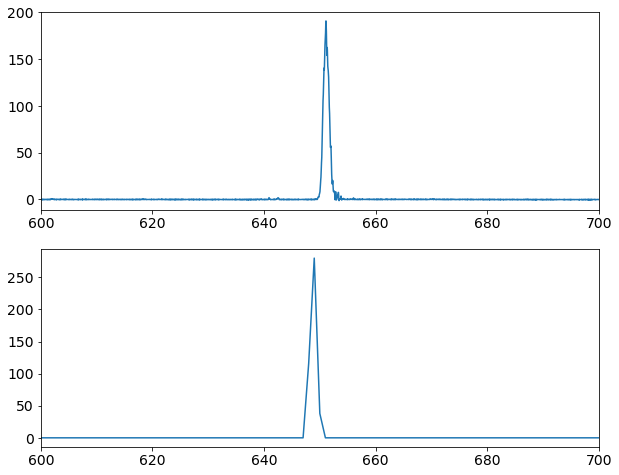

In [109]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[250]
 [898]
 [899]
 [901]
 [902]
 [903]
 [905]
 [906]
 [907]
 [913]]


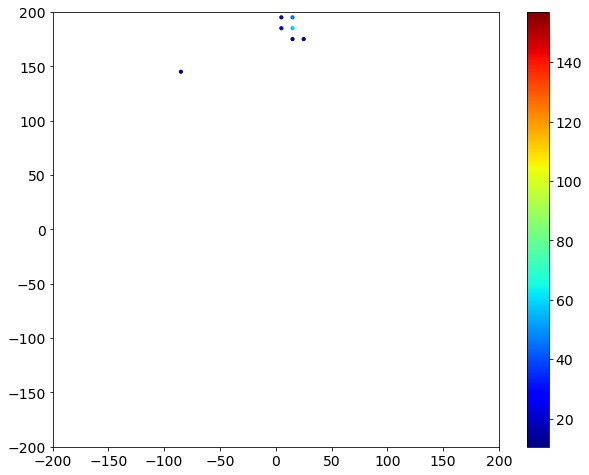

In [110]:
plot_sipm_map(sipm_cal)

### Event

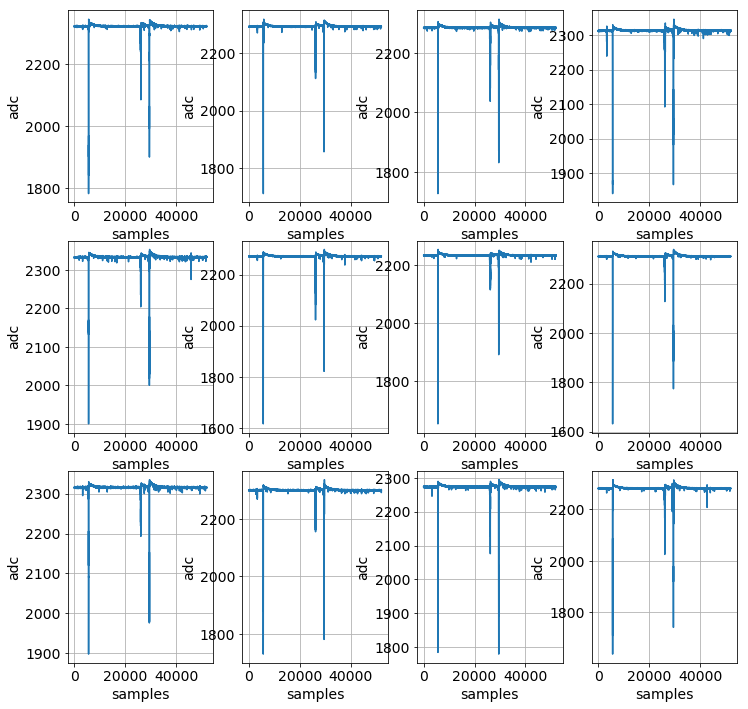

In [113]:
event=3
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

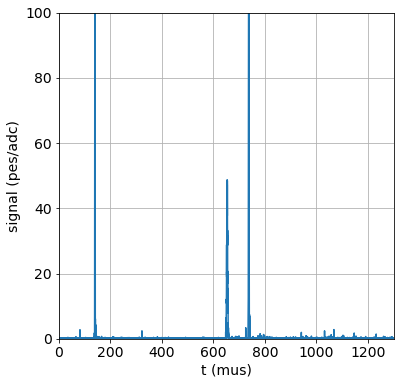

In [114]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

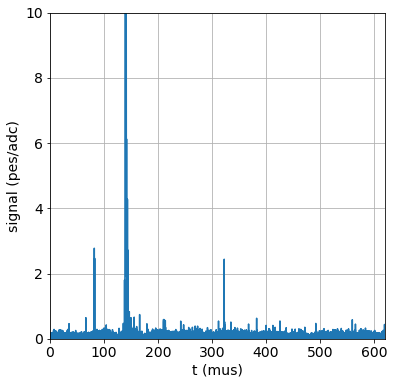

In [115]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [117]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 322.675  322.7    322.725  322.75   322.775  322.8  ] µs
 Time @ max energy: 322.75
 Width: 0.125 µs
 Height: 2.4397086337191047 pes
 Energy: 9.506044709802289 pes
 Charge: 0.0 pes
 RMS: 0.0347495628730576 µs]

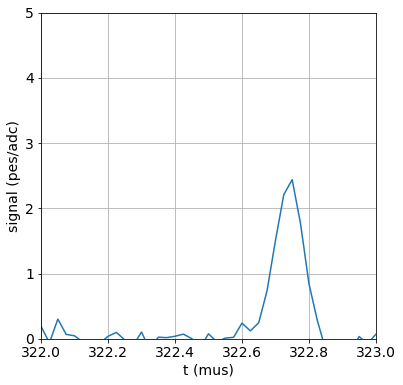

In [118]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =322,
                            t_max      = 323,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [119]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 740 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 647.94160472  648.59331699  649.55831288  650.55060848  651.53963909
 652.49251765  653.49079814  654.46522566  655.44643659  656.42522546
 657.379305    658.45855999  659.36408512] µs
       Time @ max energy: 653.490798137043
       Width: 11.422480404236238 µs
       Height: 1684.816032284331 pes
       Energy: 8109.214277139182 pes
       Charge: 125.07987371276239 pes
       RMS: 1.9007003260252828 µs]

### Event

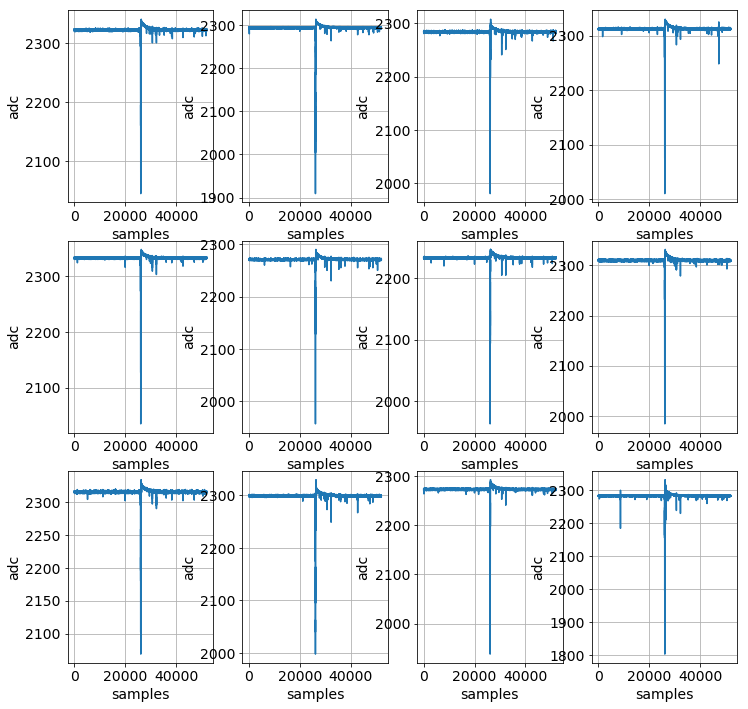

In [134]:
event=4
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

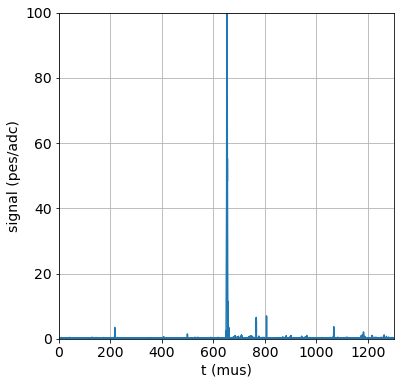

In [135]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

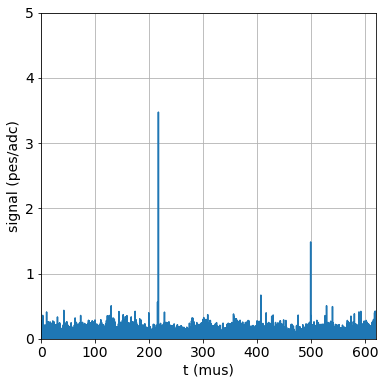

In [136]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [137]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 217.225  217.25   217.275  217.3    217.325] µs
 Time @ max energy: 217.275
 Width: 0.1 µs
 Height: 3.474843260073192 pes
 Energy: 11.916068758154982 pes
 Charge: 0.0 pes
 RMS: 0.029772170083865828 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 499.175  499.2    499.225  499.25   499.275] µs
 Time @ max energy: 499.225
 Width: 0.1 µs
 Height: 1.4845359244005352 pes
 Energy: 5.842104056217947 pes
 Charge: 0.0 pes
 RMS: 0.032301241977627716 µs]

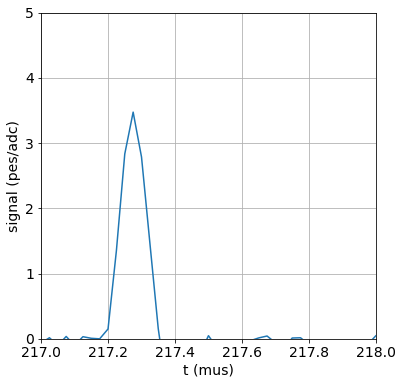

In [138]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =217,
                            t_max      = 218,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

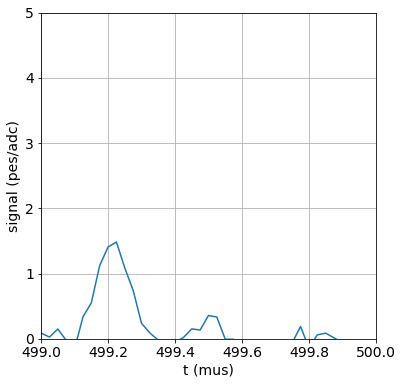

In [139]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =499,
                            t_max      = 500,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [140]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.61500058  649.59511299  650.5984304   651.58003618  652.51736613
 653.4602331   654.43129689  655.40931119  656.32850828  657.34480169
 658.35294732] µs
       Time @ max energy: 652.5173661252721
       Width: 9.73794674274209 µs
       Height: 3437.461013450172 pes
       Energy: 11959.347432661054 pes
       Charge: 385.06195315883946 pes
       RMS: 1.3539822981468512 µs]

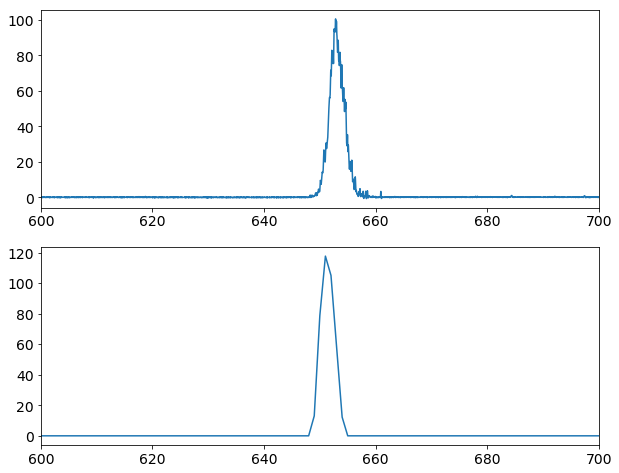

In [141]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[965]
 [966]
 [967]
 [970]
 [971]]


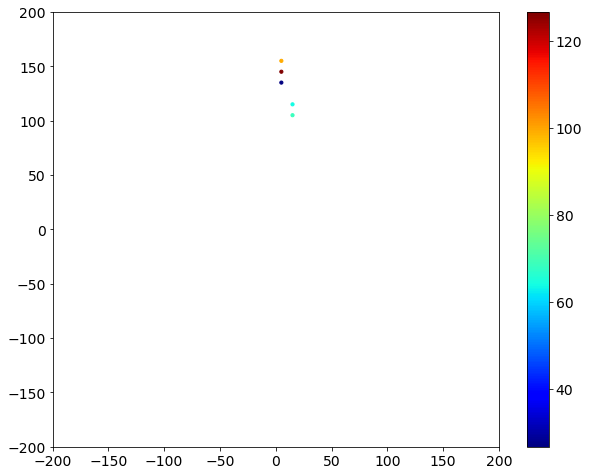

In [142]:
plot_sipm_map(sipm_cal)

### Event

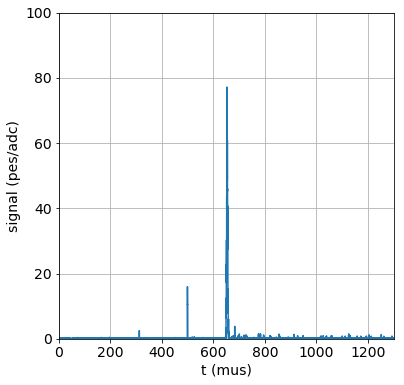

In [150]:
event=5
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

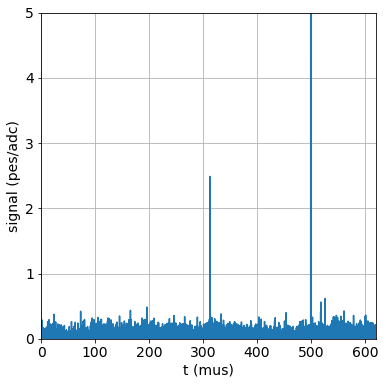

In [151]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [152]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 312.475  312.5    312.525  312.55   312.575  312.6  ] µs
 Time @ max energy: 312.525
 Width: 0.125 µs
 Height: 2.488970867282471 pes
 Energy: 10.33411228916988 pes
 Charge: 0.0 pes
 RMS: 0.03629958870333395 µs]

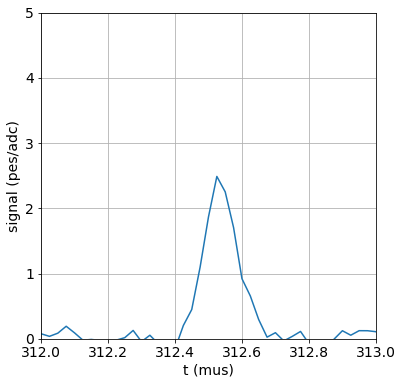

In [153]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =312,
                            t_max      = 313,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [154]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.62390392  649.64385275  650.56629582  651.54008156  652.49813613
 653.4830992   654.47238087  655.45298664  656.36849364  657.40173627
 658.43604952  659.27478875] µs
       Time @ max energy: 653.4830992033553
       Width: 10.65088483085786 µs
       Height: 2540.9637134468794 pes
       Energy: 11644.876951137036 pes
       Charge: 219.04007799272196 pes
       RMS: 1.8632847562357455 µs]

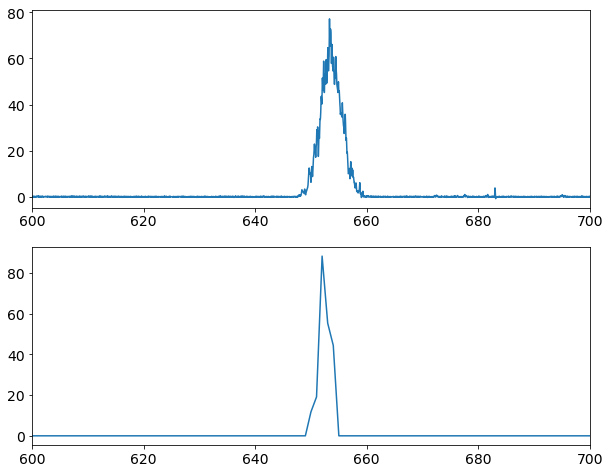

In [155]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[ 690]
 [ 691]
 [ 692]
 [ 694]
 [ 695]
 [1039]]


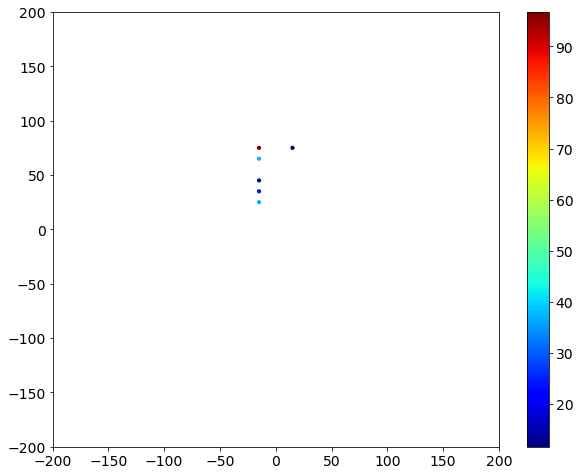

In [156]:
plot_sipm_map(sipm_cal)

### Event

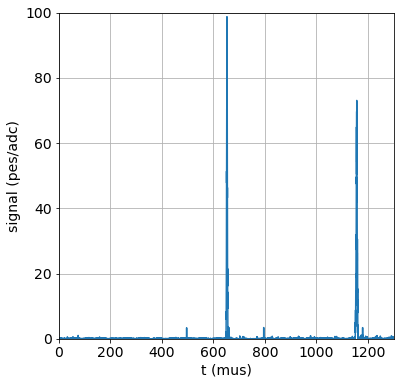

In [157]:
event=6
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

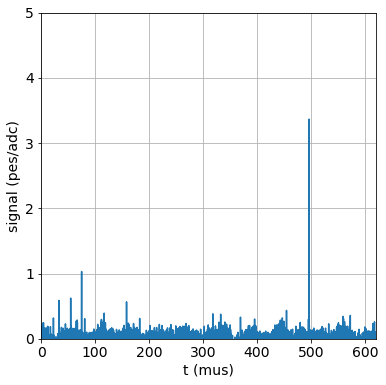

In [158]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [159]:
s1params = S12Params(time = minmax(min    = 160 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 496.225  496.25   496.275  496.3    496.325  496.35   496.375] µs
 Time @ max energy: 496.275
 Width: 0.15 µs
 Height: 3.3671386539585684 pes
 Energy: 14.941429303531558 pes
 Charge: 0.0 pes
 RMS: 0.04001209303687385 µs]

In [160]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.8135787   649.66050413  650.62130946  651.54495296  652.51166415
 653.45798798  654.41524571  655.38496869  656.3202659   657.28584156
 658.1003722 ] µs
       Time @ max energy: 652.5116641512252
       Width: 9.286793498643558 µs
       Height: 3459.895955731885 pes
       Energy: 12550.012357526968 pes
       Charge: 314.63090910373586 pes
       RMS: 1.3121745947389998 µs]

### Event

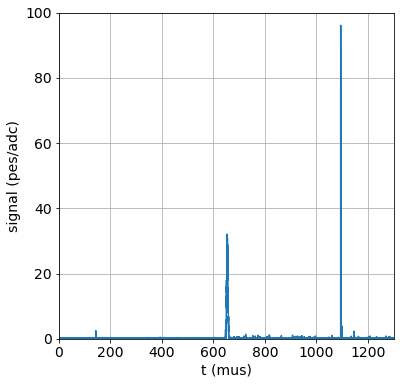

In [161]:
event=7
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

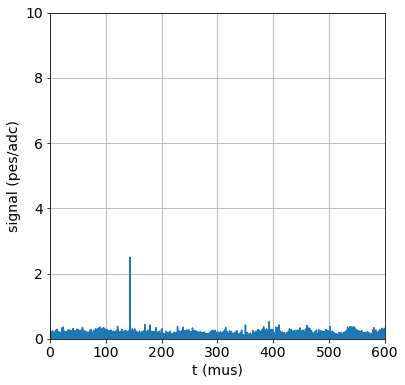

In [162]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [164]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 143.425  143.45   143.475  143.5    143.525  143.55   143.575  143.6
 143.625  143.65   143.675] µs
       Time @ max energy: 143.5
       Width: 0.25 µs
       Height: 2.4960078868327855 pes
       Energy: 12.89778083398791 pes
       Charge: 0.0 pes
       RMS: 0.06994041844449235 µs]

In [165]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 647.62858707  648.49972337  649.53176122  650.57086872  651.50171863
 652.52245588  653.49292433  654.48131862  655.47564859  656.43271643
 657.467799    658.42430627  659.36650169  660.26718067] µs
       Time @ max energy: 654.4813186196832
       Width: 12.638593605666538 µs
       Height: 1086.9595778467 pes
       Energy: 6815.586084421884 pes
       Charge: 33.55167909644828 pes
       RMS: 2.3532324611286213 µs]

### Event

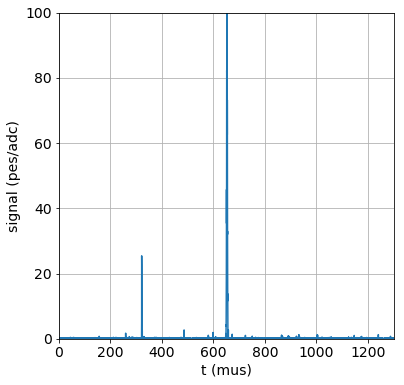

In [166]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

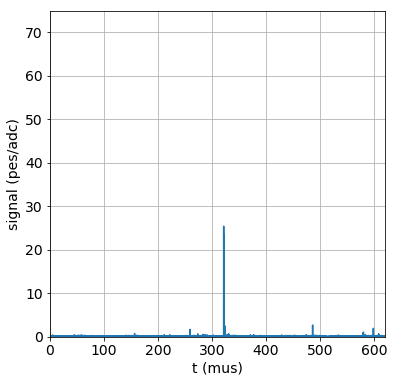

In [167]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 620,
                            signal_min =    0,
                            signal_max =  75,
                            figsize=(6,6))

In [168]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 2500),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 259.5    259.525  259.55   259.575  259.6    259.625  259.65   259.675] µs
 Time @ max energy: 259.55
 Width: 0.175 µs
 Height: 1.7199620875760657 pes
 Energy: 9.22106500250369 pes
 Charge: 0.0 pes
 RMS: 0.049865270899148585 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 40
       Times: [ 321.6    321.625  321.65   321.675  321.7    321.725  321.75   321.775
 321.8    321.825  321.85   321.875  321.9    321.925  321.95   321.975
 322.     322.025  322.05   322.075  322.1    322.125  322.15   322.175
 322.2    322.225  322.25   322.275  322.3    322.325  322.35   322.375
 322.4    322.425  322.45   322.475  322.5    322.525  322.55   322.575] µs
       Time @ max energy: 321.725
       Width: 0.9 µs
       Height: 25.430153333770118 pes
       Energy: 614.3390677897197 pes
       Charge: 0.0 pes
       RMS: 0.21989676872383995 µs, 
 -

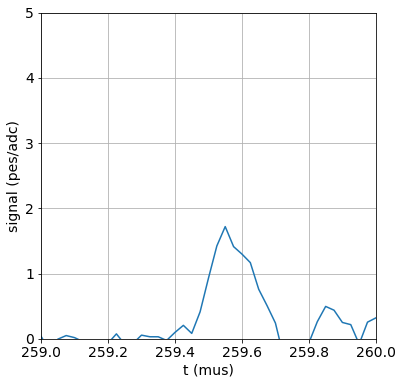

In [170]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =259,
                            t_max      = 260,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

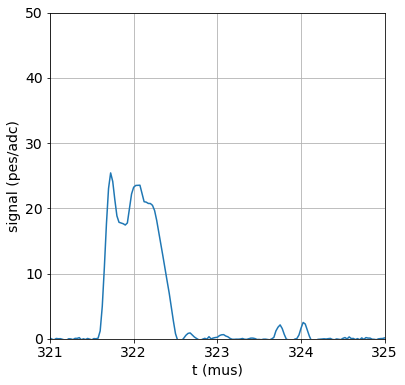

In [172]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =321,
                            t_max      = 325,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

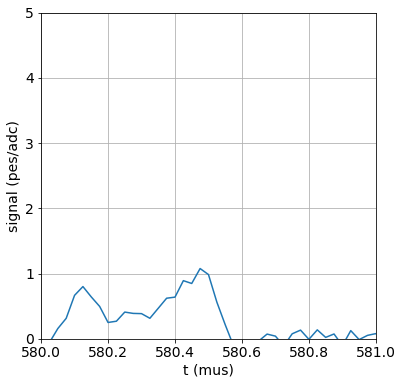

In [173]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =580,
                            t_max      = 581,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

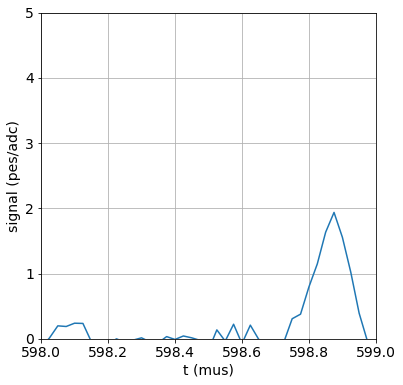

In [174]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =598,
                            t_max      = 599,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [175]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 1000 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.80998978  649.60379371  650.63892267  651.55867726  652.4971107
 653.46739561  654.42183944  655.39588598  656.30496574  657.23084283
 658.16597464] µs
       Time @ max energy: 652.4971106985372
       Width: 9.355984860671452 µs
       Height: 3707.8776508019646 pes
       Energy: 13356.644333767503 pes
       Charge: 33.55167909644828 pes
       RMS: 1.3319773647090543 µs]

### Event

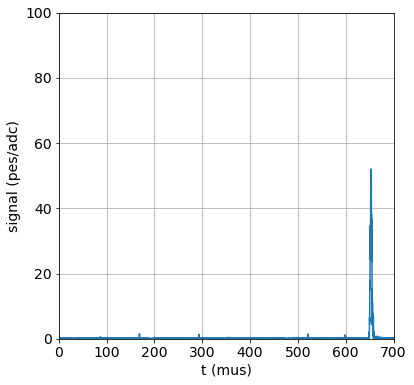

In [176]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

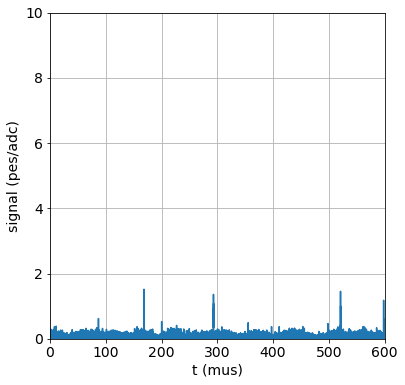

In [177]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [187]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 168.425  168.45   168.475  168.5    168.525  168.55   168.575  168.6
 168.625  168.65   168.675  168.7  ] µs
       Time @ max energy: 168.5
       Width: 0.275 µs
       Height: 1.5189555224338978 pes
       Energy: 13.829326977078342 pes
       Charge: 0.0 pes
       RMS: 0.07961781913432313 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 520.675  520.7    520.725  520.75   520.775] µs
 Time @ max energy: 520.725
 Width: 0.1 µs
 Height: 1.4563550985566973 pes
 Energy: 5.46794856235365 pes
 Charge: 0.0 pes
 RMS: 0.030092538322311575 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 597.925  597.95   597.975  598.     598.025] µs
 Time @ max energy: 598.0
 Width: 0.1 µs
 Height: 1.1805891268577586 pes
 Energy: 4.976696705938541 pes
 Charge: 0.0 pes
 RMS: 0.033135212451241

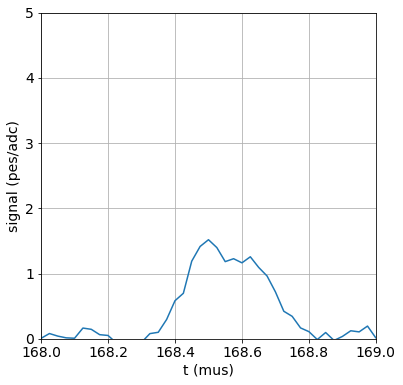

In [179]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =168,
                            t_max      = 169,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

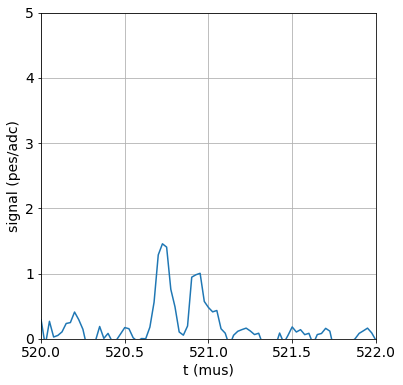

In [183]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =520,
                            t_max      = 522,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

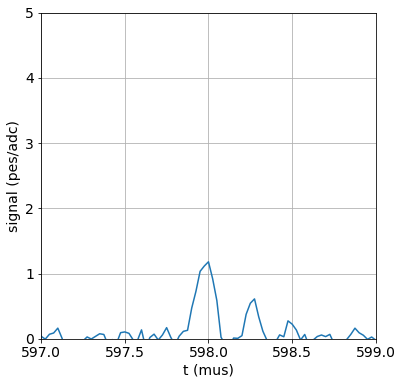

In [185]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =597,
                            t_max      = 599,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [186]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.82700635  649.65121233  650.56712212  651.52072669  652.50341114
 653.45651507  654.41940778  655.42383867  656.46150412  657.46643068
 658.43871998] µs
       Time @ max energy: 652.5034111433898
       Width: 9.611713628924102 µs
       Height: 1798.7843652959011 pes
       Energy: 7189.526957848389 pes
       Charge: 33.55167909644828 pes
       RMS: 1.6226952711090539 µs]

### Event

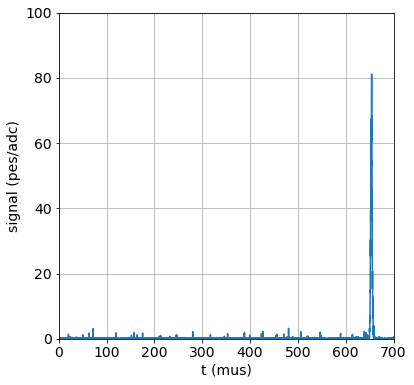

In [188]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

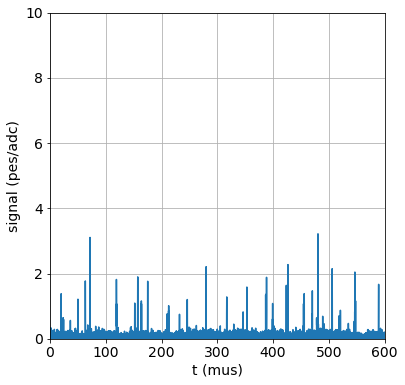

In [189]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [190]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 151.9    151.925  151.95   151.975  152.     152.025  152.05   152.075
 152.1    152.125  152.15 ] µs
       Time @ max energy: 151.95
       Width: 0.25 µs
       Height: 1.094244717871133 pes
       Energy: 8.21297439245313 pes
       Charge: 0.0 pes
       RMS: 0.07196422810677738 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 157.075  157.1    157.125  157.15   157.175  157.2    157.225  157.25
 157.275  157.3    157.325  157.35   157.375  157.4  ] µs
       Time @ max energy: 157.35
       Width: 0.325 µs
       Height: 1.8980353800355996 pes
       Energy: 15.655939622479702 pes
       Charge: 0.0 pes
       RMS: 0.09853650408220457 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 163.75   163.775  163.8    163.825] µs
 Time @ max en

In [191]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.71628929  650.5919812   651.54704779  652.52809649  653.49420291
 654.45042825  655.39757651  656.42577779  657.36314987  658.42890859] µs
       Time @ max energy: 653.4942029131885
       Width: 8.712619300824823 µs
       Height: 2549.3758895379033 pes
       Energy: 10366.477062444726 pes
       Charge: 33.55167909644828 pes
       RMS: 1.4966738922254035 µs]

In [192]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=10,
                          bls_mode=csf.BlsMode.mode)



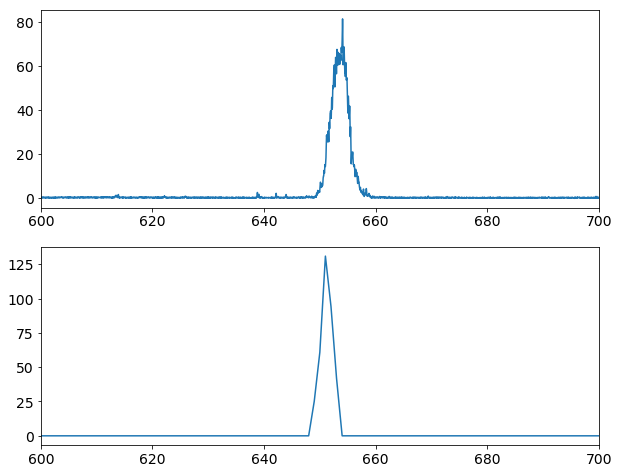

In [193]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

[[1280]
 [1283]
 [1284]
 [1285]
 [1286]
 [1289]
 [1290]]


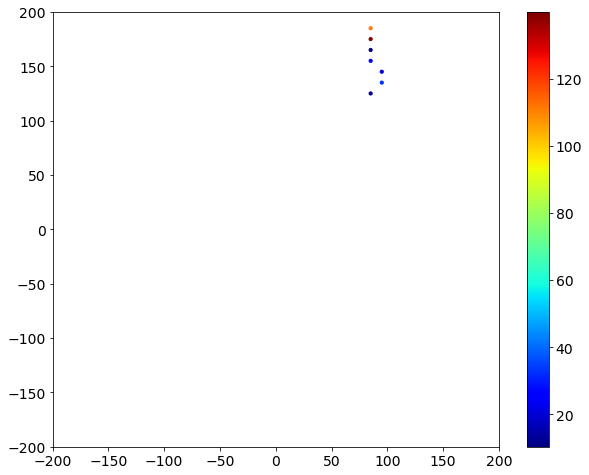

In [195]:
plot_sipm_map(sipm_cal)

### Event

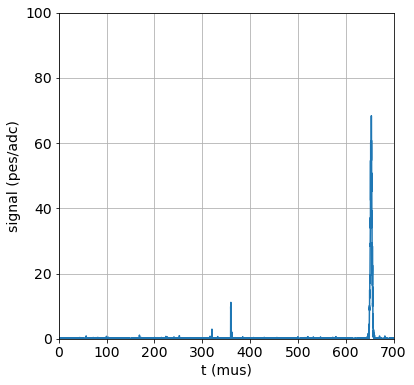

In [198]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

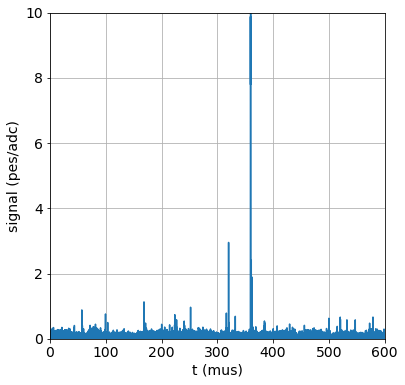

In [199]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [200]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 251.975  252.     252.025  252.05 ] µs
 Time @ max energy: 252.025
 Width: 0.075 µs
 Height: 0.9670624414871549 pes
 Energy: 3.271793698772081 pes
 Charge: 0.0 pes
 RMS: 0.026453035955559704 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 320.1    320.125  320.15   320.175  320.2  ] µs
 Time @ max energy: 320.15
 Width: 0.1 µs
 Height: 2.954222021534535 pes
 Energy: 10.628471648242385 pes
 Charge: 0.0 pes
 RMS: 0.030597234719281788 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 360.725  360.75   360.775  360.8    360.825  360.85 ] µs
 Time @ max energy: 360.775
 Width: 0.125 µs
 Height: 2.4060474434727053 pes
 Energy: 8.306914213836103 pes
 Charge: 0.0 pes
 RMS: 0.030547538476391207 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 361.     361.025  361.

In [201]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 646.9638163   647.58424203  648.6187642   649.58726047  650.54565047
 651.52911197  652.49385066  653.48667583  654.44234688  655.42891513
 656.39254587  657.37812851  658.33878523  659.48180557  660.        ] µs
       Time @ max energy: 653.4866758291238
       Width: 13.036183698247653 µs
       Height: 2281.555005698304 pes
       Energy: 10338.84047727485 pes
       Charge: 352.7172328455672 pes
       RMS: 1.7757631764961594 µs]

### Event

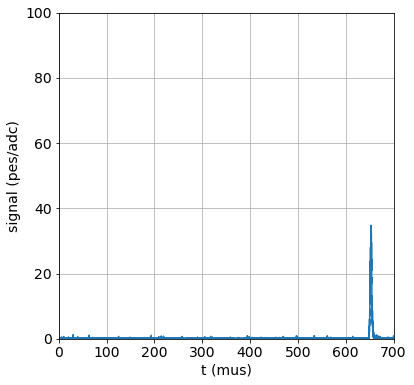

In [202]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

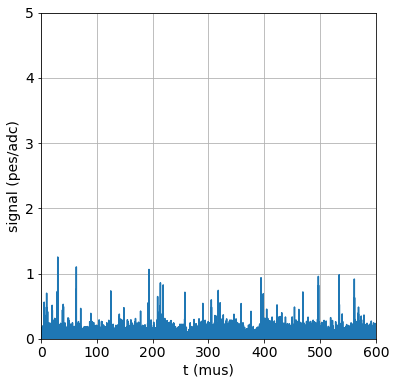

In [204]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [205]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 193.35   193.375  193.4    193.425] µs
 Time @ max energy: 193.375
 Width: 0.075 µs
 Height: 1.0632850686739033 pes
 Energy: 3.424540648582614 pes
 Charge: 0.0 pes
 RMS: 0.027042758976631855 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 213.8    213.825  213.85   213.875] µs
 Time @ max energy: 213.85
 Width: 0.075 µs
 Height: 0.8580716956817092 pes
 Energy: 2.4236848391416115 pes
 Charge: 0.0 pes
 RMS: 0.024889766145506677 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 394.125  394.15   394.175  394.2  ] µs
 Time @ max energy: 394.175
 Width: 0.075 µs
 Height: 0.9364874896588425 pes
 Energy: 3.293020738364194 pes
 Charge: 0.0 pes
 RMS: 0.026955265931238197 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 533.875  533.9    533.925  533.95 ] µs
 Time @

In [206]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 647.975       648.54769652  649.57031638  650.56065572  651.53694539
 652.48093975  653.46864965  654.42031741  655.42121325  656.39525754
 657.38790056  658.15198845] µs
       Time @ max energy: 652.480939754292
       Width: 10.176988452415332 µs
       Height: 1081.2636252085708 pes
       Energy: 4794.630997241427 pes
       Charge: 352.7172328455672 pes
       RMS: 1.7395122163304388 µs]

### Event

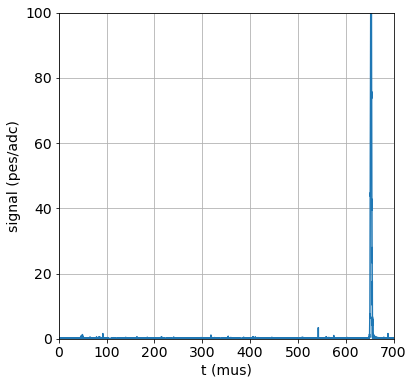

In [207]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

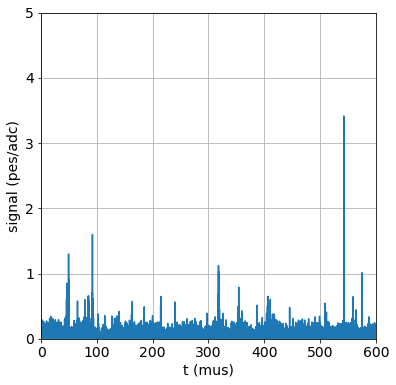

In [208]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [209]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 542.475  542.5    542.525  542.55   542.575  542.6    542.625  542.65 ] µs
 Time @ max energy: 542.525
 Width: 0.175 µs
 Height: 3.415303373183909 pes
 Energy: 18.684833956637778 pes
 Charge: 0.0 pes
 RMS: 0.04758849973385544 µs]

In [210]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.77283364  650.68229491  651.55703236  652.50706916  653.44449967
 654.40894437  655.31711887  656.12595639] µs
       Time @ max energy: 652.5070691637951
       Width: 6.3531227501967225 µs
       Height: 4430.475176001959 pes
       Energy: 13898.940811374689 pes
       Charge: 352.7172328455672 pes
       RMS: 1.0864711894670702 µs]

### Event

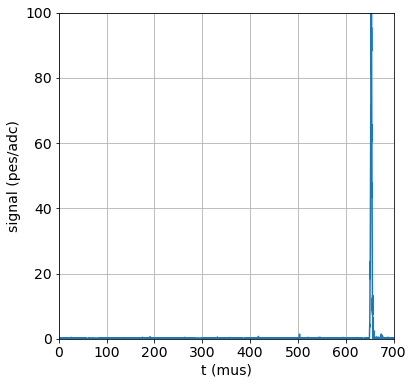

In [211]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

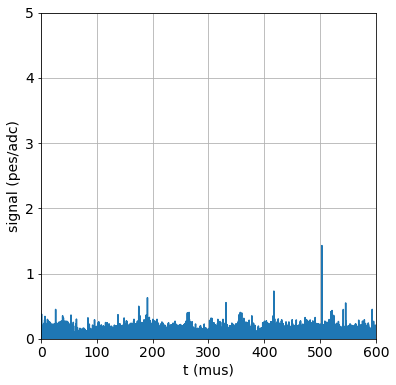

In [212]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [213]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 503.2    503.225  503.25   503.275  503.3    503.325  503.35   503.375
 503.4    503.425  503.45 ] µs
       Time @ max energy: 503.25
       Width: 0.25 µs
       Height: 1.4292512204659633 pes
       Energy: 10.667621268332352 pes
       Charge: 0.0 pes
       RMS: 0.08448633605608695 µs]

In [214]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 649.77956905  650.63896194  651.5885921   652.53384805  653.47369955
 654.42745362  655.35428667  656.34346793  657.28939886  658.63493847
 659.14937902] µs
       Time @ max energy: 653.4736995532114
       Width: 9.369809975588694 µs
       Height: 3935.1689348400696 pes
       Energy: 12822.19779574101 pes
       Charge: 352.7172328455672 pes
       RMS: 1.2770795577878473 µs]

### Event

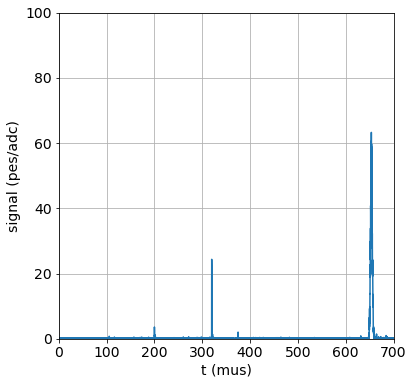

In [215]:
event=15
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

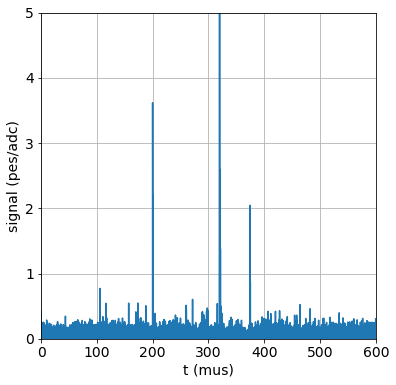

In [216]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [217]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 320.65   320.675  320.7    320.725] µs
 Time @ max energy: 320.7
 Width: 0.075 µs
 Height: 2.594548309314721 pes
 Energy: 8.186980069840654 pes
 Charge: 0.0 pes
 RMS: 0.025173195334023395 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 374.725  374.75   374.775  374.8    374.825] µs
 Time @ max energy: 374.775
 Width: 0.1 µs
 Height: 2.04586834987604 pes
 Energy: 7.97591205429793 pes
 Charge: 0.0 pes
 RMS: 0.03238497611936401 µs]

In [218]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.5620238   649.53341867  650.58799371  651.53680681  652.51513073
 653.49276897  654.45613764  655.44620222  656.42980944  657.33820176
 658.46053412  659.10007885] µs
       Time @ max energy: 653.4927689704319
       Width: 10.538055043418659 µs
       Height: 2156.4741510132285 pes
       Energy: 9987.973433732064 pes
       Charge: 352.7172328455672 pes
       RMS: 1.8081181036956293 µs]

### Event

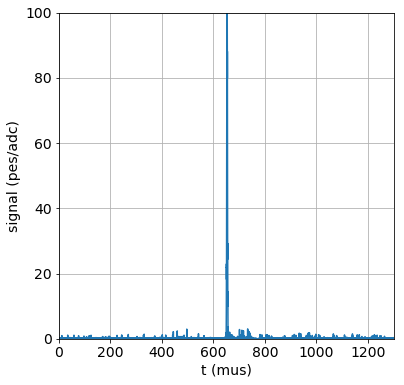

In [235]:
event=16
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

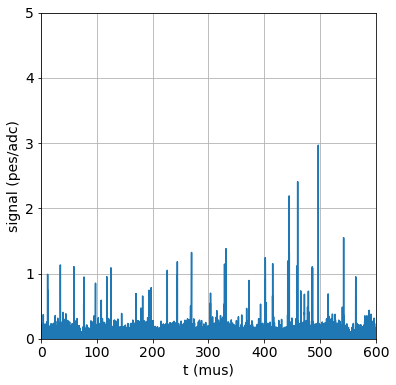

In [220]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

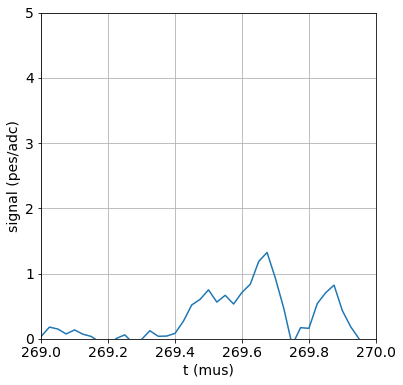

In [224]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =269,
                            t_max      = 270,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

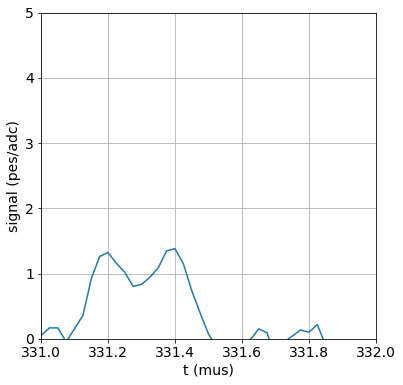

In [225]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =331,
                            t_max      = 332,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

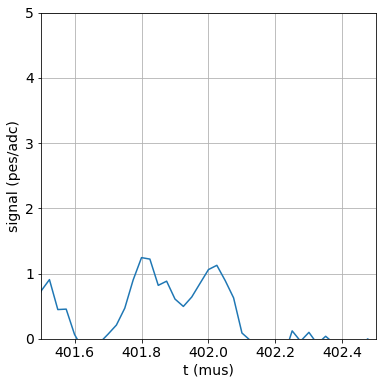

In [226]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =401.5,
                            t_max      = 402.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [ ]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =331,
                            t_max      = 332,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

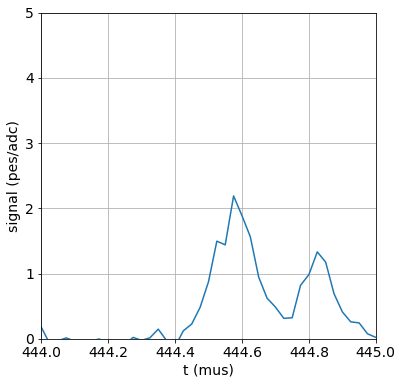

In [228]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =444,
                            t_max      = 445,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

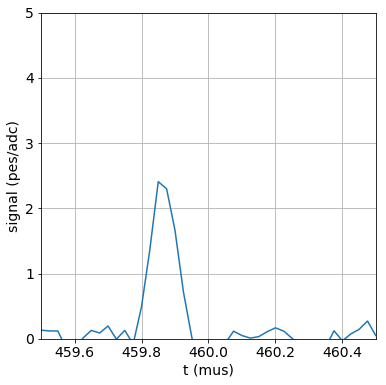

In [231]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =459.5,
                            t_max      = 460.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

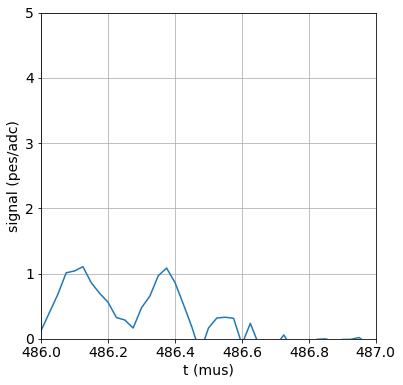

In [232]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =486,
                            t_max      = 487,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

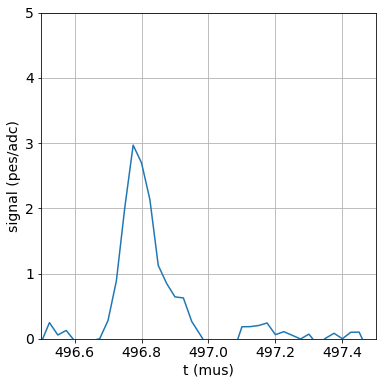

In [234]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =496.5,
                            t_max      = 497.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

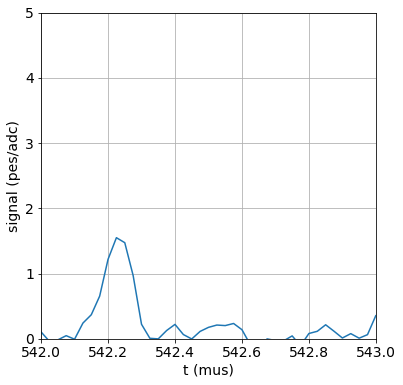

In [236]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =542,
                            t_max      = 543,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [229]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 269.625  269.65   269.675  269.7  ] µs
 Time @ max energy: 269.675
 Width: 0.075 µs
 Height: 1.3235602065717413 pes
 Energy: 4.27244270772241 pes
 Charge: 0.0 pes
 RMS: 0.025899483006638153 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 331.15   331.175  331.2    331.225  331.25   331.275  331.3    331.325
 331.35   331.375  331.4    331.425] µs
       Time @ max energy: 331.4
       Width: 0.275 µs
       Height: 1.3817064270753012 pes
       Energy: 13.231659832894898 pes
       Charge: 0.0 pes
       RMS: 0.08896508335879126 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 401.775  401.8    401.825  401.85   401.875  401.9    401.925  401.95
 401.975  402.     402.025  402.05 ] µs
       Time @ max energy: 401.8
       Width: 0.275 µs
 

In [237]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.59962561  649.65922436  650.60516414  651.5911197   652.5387537
 653.47300343  654.44620124  655.37390195  656.35752112  657.3478325
 658.03048049] µs
       Time @ max energy: 653.4730034276685
       Width: 9.430854880574858 µs
       Height: 4226.292423020128 pes
       Energy: 14619.758406125964 pes
       Charge: 352.7172328455672 pes
       RMS: 1.3113627053003296 µs]

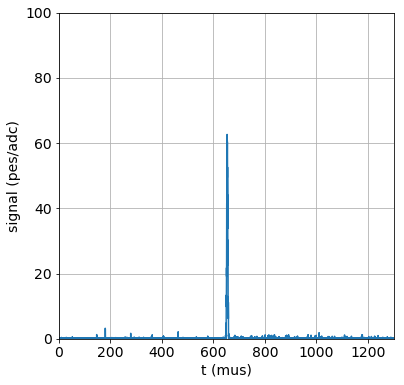

In [238]:
event=17
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

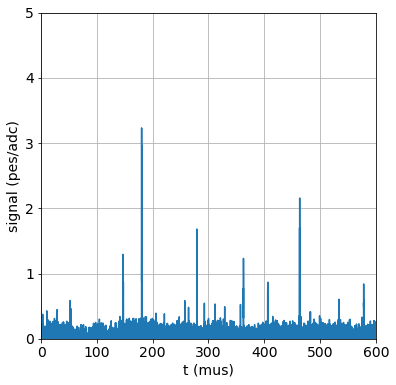

In [240]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

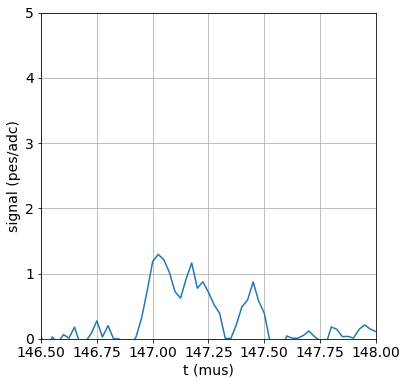

In [243]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =146.5,
                            t_max      = 148,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

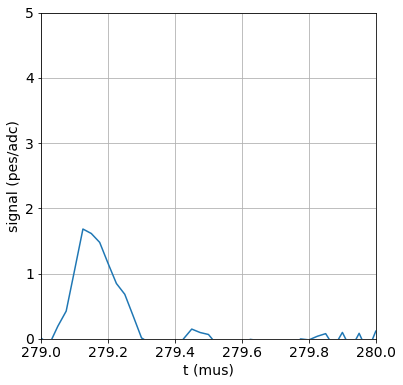

In [245]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =279,
                            t_max      = 280,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

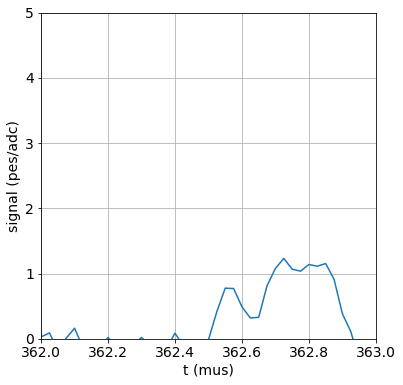

In [246]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =362,
                            t_max      = 363,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

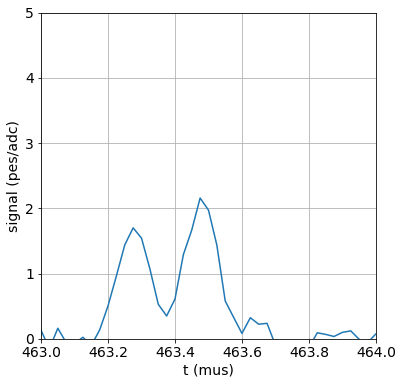

In [247]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =463,
                            t_max      = 464,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [241]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 147.     147.025  147.05   147.075  147.1    147.125  147.15   147.175
 147.2    147.225] µs
       Time @ max energy: 147.025
       Width: 0.225 µs
       Height: 1.2947728874020812 pes
       Energy: 9.788562471797709 pes
       Charge: 0.0 pes
       RMS: 0.07380210835507747 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 279.1    279.125  279.15   279.175  279.2    279.225  279.25 ] µs
 Time @ max energy: 279.125
 Width: 0.15 µs
 Height: 1.682665557825965 pes
 Energy: 8.51245485254619 pes
 Charge: 0.0 pes
 RMS: 0.0447364281495785 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 362.55   362.575  362.6    362.625  362.65   362.675  362.7    362.725
 362.75   362.775  362.8    362.825  362.85   362.875] µs
       Time @ max energy: 362.7

In [248]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 647.5277085   648.58893729  649.57865398  650.54942924  651.54335651
 652.50059648  653.48152976  654.46024621  655.47267291  656.46614498
 657.38450752  658.35579364  659.32138878] µs
       Time @ max energy: 653.4815297597278
       Width: 11.793680279782508 µs
       Height: 2180.0686751346575 pes
       Energy: 11093.538518159361 pes
       Charge: 352.7172328455672 pes
       RMS: 1.9731451582333142 µs]

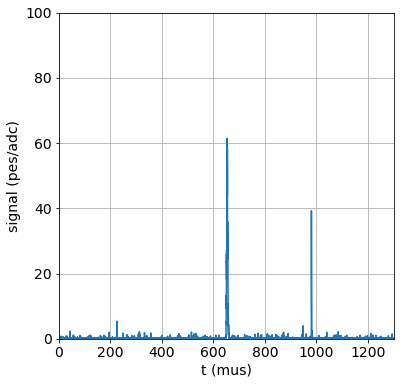

In [249]:
event=18
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

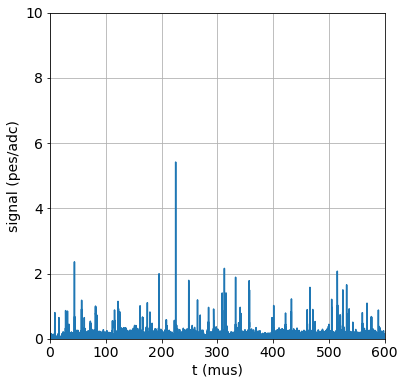

In [250]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

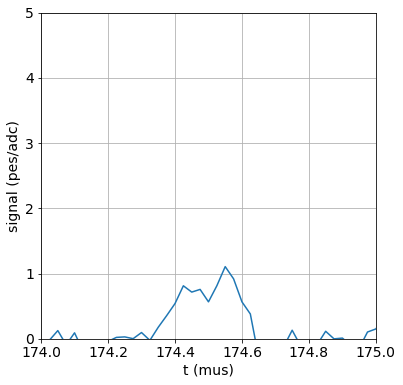

In [253]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =174,
                            t_max      = 175,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

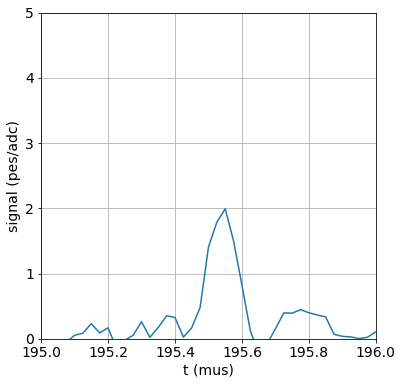

In [254]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =195,
                            t_max      = 196,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

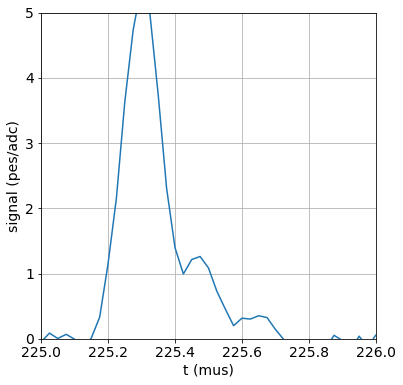

In [255]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =225,
                            t_max      = 226,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

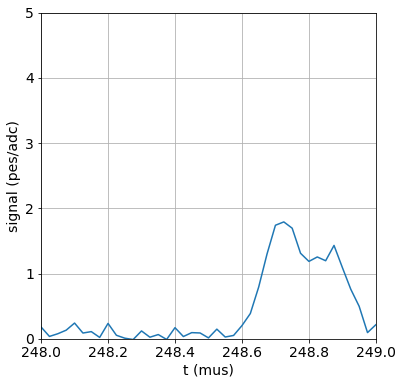

In [256]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =248,
                            t_max      = 249,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

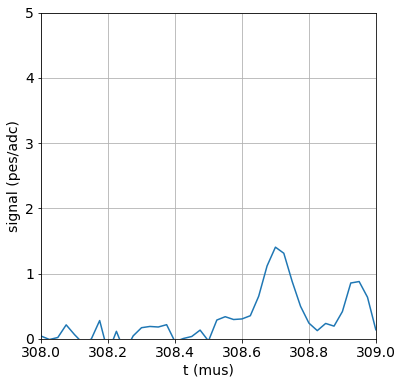

In [257]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =308,
                            t_max      = 309,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

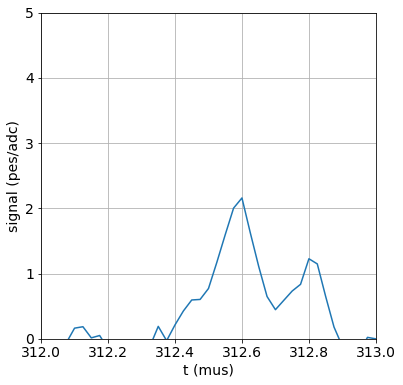

In [258]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =312,
                            t_max      = 313,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

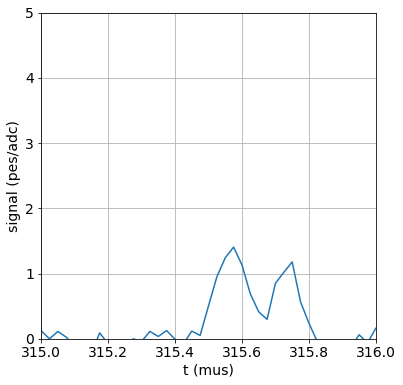

In [259]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =315,
                            t_max      = 316,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

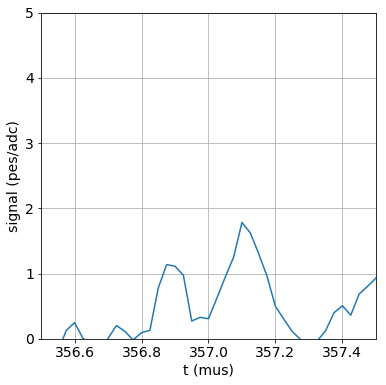

In [260]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =356.5,
                            t_max      = 357.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

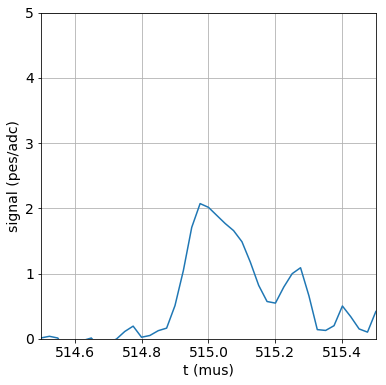

In [262]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =514.5,
                            t_max      = 515.5,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [251]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 174.425  174.45   174.475  174.5    174.525  174.55   174.575] µs
 Time @ max energy: 174.55
 Width: 0.15 µs
 Height: 1.106590336857153 pes
 Energy: 5.690762598582469 pes
 Charge: 0.0 pes
 RMS: 0.05156428050160891 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 195.5    195.525  195.55   195.575] µs
 Time @ max energy: 195.55
 Width: 0.075 µs
 Height: 1.994008198103169 pes
 Energy: 6.683958026180283 pes
 Charge: 0.0 pes
 RMS: 0.026427420432590873 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 225.2    225.225  225.25   225.275  225.3    225.325  225.35   225.375
 225.4    225.425  225.45   225.475  225.5    225.525] µs
       Time @ max energy: 225.3
       Width: 0.325 µs
       Height: 5.418645671583227 pes
       Energy: 34.79278338722045 pes
       Charge: 0.0 pes


In [263]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.85660858  649.64035121  650.52438581  651.49790363  652.51433929
 653.48457417  654.46784048  655.46761213  656.43411654  657.39336899
 658.38587077  659.33148396] µs
       Time @ max energy: 653.4845741705309
       Width: 10.474875382765894 µs
       Height: 2069.0214084086683 pes
       Energy: 9837.568133463637 pes
       Charge: 352.7172328455672 pes
       RMS: 1.9205517531338723 µs]

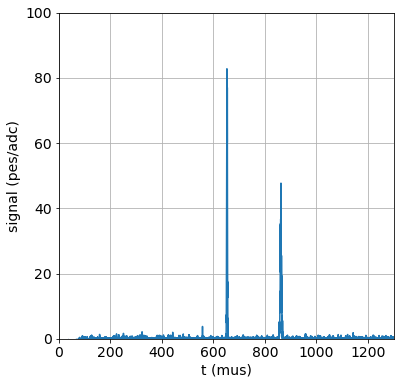

In [264]:
event=19
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

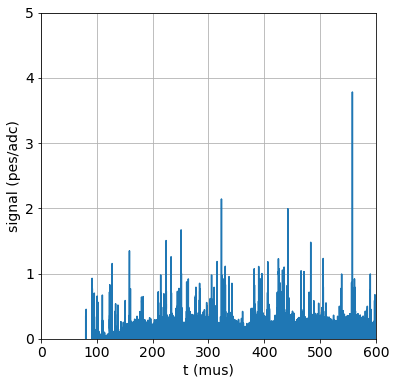

In [266]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

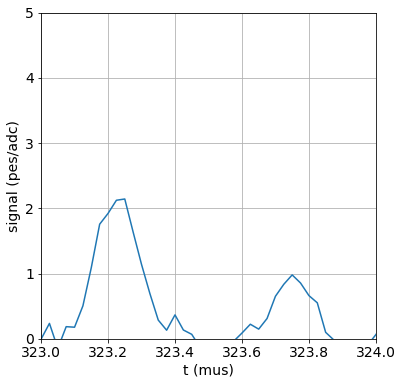

In [269]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =323,
                            t_max      = 324,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [267]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 700 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)


s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 9
       Times: [ 649.66747129  650.62778096  651.56338094  652.52078803  653.48207905
 654.43148024  655.40283962  656.36511504  657.43153762] µs
       Time @ max energy: 653.4820790542964
       Width: 7.764066333054798 µs
       Height: 2920.879433705418 pes
       Energy: 10956.366591685699 pes
       Charge: 352.7172328455672 pes
       RMS: 1.3195319738774927 µs]

In [268]:
s1params = S12Params(time = minmax(min    = 140 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 25),  #250 ns -- 50 ns
                           rebin_stride  = 1)
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.75 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=sipm_cal, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 158.325  158.35   158.375  158.4  ] µs
 Time @ max energy: 158.35
 Width: 0.075 µs
 Height: 1.3488009973738841 pes
 Energy: 4.351797530796069 pes
 Charge: 0.0 pes
 RMS: 0.026894148865496164 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 224.     224.025  224.05   224.075  224.1    224.125  224.15 ] µs
 Time @ max energy: 224.1
 Width: 0.15 µs
 Height: 1.5060027726143252 pes
 Energy: 7.969719444840063 pes
 Charge: 0.0 pes
 RMS: 0.045887637177808804 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 232.975  233.     233.025  233.05 ] µs
 Time @ max energy: 233.0
 Width: 0.075 µs
 Height: 1.2573767515434804 pes
 Energy: 4.305142592631121 pes
 Charge: 0.0 pes
 RMS: 0.026633038710342095 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 250.925  250.95   250.975

### Conclusions

- Deconvolution correct
- Not clear how to select S1
- Not clear dependence of S1 light with Z
- Need to try selection including PMT counting. 
- Need to try selection on "peaky stuff" as opposed to "flat stuff"